<h1><b>Inf1038 - Aprendizado Automático<b></h1>
<h4><b>Grupo:</b></h4> 
 - Eduardo Luna: 2111484 <br>
 - Luca Ribeiro: 2112662 <br>
 - Lucas Larios: 2020723 <br>

In [1]:
import eli5
import numpy as np
import pandas as pd
import re
import seaborn as sns
import tensorflow as tf
from eli5.sklearn import PermutationImportance
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVR
from tensorflow.keras import layers
from xgboost import XGBRegressor
from yellowbrick.model_selection import ValidationCurve

In [2]:
# data set https://www.kaggle.com/datasets/samanemami/renewable-energy-and-weather-conditions
df = pd.read_csv('/kaggle/input/renewable-energy-and-weather-conditions/solar_weather.csv', parse_dates = ['Time'])
 
display(df)

Time  Energy delta[Wh]   GHI  temp  pressure  humidity  \
0      2017-01-01 00:00:00                 0   0.0   1.6      1021       100   
1      2017-01-01 00:15:00                 0   0.0   1.6      1021       100   
2      2017-01-01 00:30:00                 0   0.0   1.6      1021       100   
3      2017-01-01 00:45:00                 0   0.0   1.6      1021       100   
4      2017-01-01 01:00:00                 0   0.0   1.7      1020       100   
...                    ...               ...   ...   ...       ...       ...   
196771 2022-08-31 16:45:00               118  23.7  18.6      1023        57   
196772 2022-08-31 17:00:00                82  15.6  18.5      1023        61   
196773 2022-08-31 17:15:00                51   8.0  18.5      1023        61   
196774 2022-08-31 17:30:00                24   2.1  18.5      1023        61   
196775 2022-08-31 17:45:00                 0   0.0  18.5      1023        61   

        wind_speed  rain_1h  snow_1h  clouds_all  isSun  sunlightTime  \
0              4.9      0.0      0.0         100      0             0   
1              4.9      0.0      0.0         100      0             0   
2              4.9      0.0      0.0         100      0             0   
3              4.9      0.0      0.0         100      0             0   
4              5.2      0.0      0.0         100      0             0   
...            ...      ...      ...         ...    ...           ...   
196771         3.8      0.0      0.0          52      1           780   
196772         4.2      0.0      0.0          60      1           795   
196773         4.2      0.0      0.0          60      1           810   
196774         4.2      0.0      0.0          60      1           825   
196775         4.2      0.0      0.0          60      0             0   

        dayLength  SunlightTime/daylength  weather_type  hour  month  
0             450                    0.00             4     0      1  
1             450                    0.00             4     0      1  
2             450                    0.00             4     0      1  
3             450                    0.00             4     0      1  
4             450                    0.00             4     1      1  
...           ...                     ...           ...   ...    ...  
196771        825                    0.95             3    16      8  
196772        825                    0.96             3    17      8  
196773        825                    0.98             3    17      8  
196774        825                    1.00             3    17      8  
196775        825                    0.00             3    17      8  

[196776 rows x 17 columns]

In [3]:
df['weather_type'] = df['weather_type'].astype('category')

# Análise Exploratória dos Dados

In [4]:
print(f'Dataset features = {df.columns}')

Dataset features = Index(['Time', 'Energy delta[Wh]', 'GHI', 'temp', 'pressure', 'humidity',
       'wind_speed', 'rain_1h', 'snow_1h', 'clouds_all', 'isSun',
       'sunlightTime', 'dayLength', 'SunlightTime/daylength', 'weather_type',
       'hour', 'month'],
      dtype='object')


## Análise para verificar a incidência de valores nulos no dataset

In [5]:
nulls_df = pd.DataFrame(df.isnull().sum(), columns = ['Null amount'])

display(nulls_df.T)

print(f"\nTotal null values = {np.sum(nulls_df.values)}")

Time  Energy delta[Wh]  GHI  temp  pressure  humidity  \
Null amount     0                 0    0     0         0         0   

             wind_speed  rain_1h  snow_1h  clouds_all  isSun  sunlightTime  \
Null amount           0        0        0           0      0             0   

             dayLength  SunlightTime/daylength  weather_type  hour  month  
Null amount          0                       0             0     0      0


Total null values = 0


## Análise sobre a distribuição dos atributos numéricos do dataset

In [6]:
display(df.describe())

Time  Energy delta[Wh]            GHI  \
count                         196776     196776.000000  196776.000000   
mean   2019-10-29 22:44:12.085620992        573.008228      32.596538   
min              2017-01-01 00:00:00          0.000000       0.000000   
25%              2018-06-02 10:26:15          0.000000       0.000000   
50%              2019-10-28 20:52:30          0.000000       1.600000   
75%              2021-03-24 07:18:45        577.000000      46.800000   
max              2022-08-31 17:45:00       5020.000000     229.200000   
std                              NaN       1044.824047      52.172018   

                temp       pressure       humidity     wind_speed  \
count  196776.000000  196776.000000  196776.000000  196776.000000   
mean        9.790521    1015.292780      79.810566       3.937746   
min       -16.600000     977.000000      22.000000       0.000000   
25%         3.600000    1010.000000      70.000000       2.600000   
50%         9.300000    1016.000000      84.000000       3.700000   
75%        15.700000    1021.000000      92.000000       5.000000   
max        35.800000    1047.000000     100.000000      14.300000   
std         7.995428       9.585773      15.604459       1.821694   

             rain_1h        snow_1h     clouds_all          isSun  \
count  196776.000000  196776.000000  196776.000000  196776.000000   
mean        0.066035       0.007148      65.974387       0.519962   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000      34.000000       0.000000   
50%         0.000000       0.000000      82.000000       1.000000   
75%         0.000000       0.000000     100.000000       1.000000   
max         8.090000       2.820000     100.000000       1.000000   
std         0.278913       0.069710      36.628593       0.499603   

        sunlightTime      dayLength  SunlightTime/daylength           hour  \
count  196776.000000  196776.000000           196776.000000  196776.000000   
mean      211.721094     748.644347                0.265187      11.498902   
min         0.000000     450.000000                0.000000       0.000000   
25%         0.000000     570.000000                0.000000       5.000000   
50%        30.000000     765.000000                0.050000      11.000000   
75%       390.000000     930.000000                0.530000      17.000000   
max      1020.000000    1020.000000                1.000000      23.000000   
std       273.902186     194.870208                0.329023       6.921887   

               month  
count  196776.000000  
mean        6.298329  
min         1.000000  
25%         3.000000  
50%         6.000000  
75%         9.000000  
max        12.000000  
std         3.376066

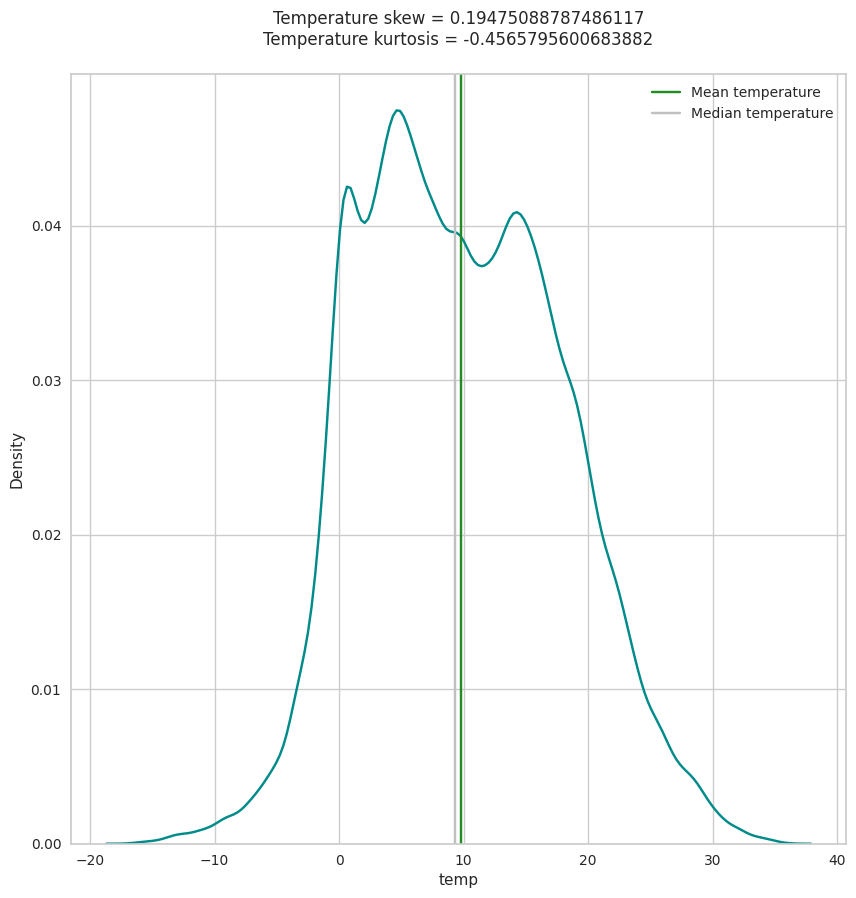

In [7]:
temp_distribution = f"Temperature skew = {df['temp'].skew()}\n" + f"Temperature kurtosis = {df['temp'].kurtosis()}\n"

fig, ax = plt.subplots(figsize = (10,10))

sns.kdeplot(data = df['temp'], color = 'DarkCyan', ax = ax).set_title(temp_distribution)

ax.axvline(x = df['temp'].mean(), color = 'ForestGreen', label = 'Mean temperature')
ax.axvline(x = df['temp'].median(), color = 'Silver', label = 'Median temperature')

plt.legend()

plt.show()

A partir do gráfico acima é possível notar uma leve assimetria, com uma cauda direita na distribuição, indicada ainda pelo valor "skew" ser maior do que zero. 
Pelo coeficiente de curtose, concluí-se que a distribuição é leptocúrtica, sendo mais concentrada que uma distribuição normal

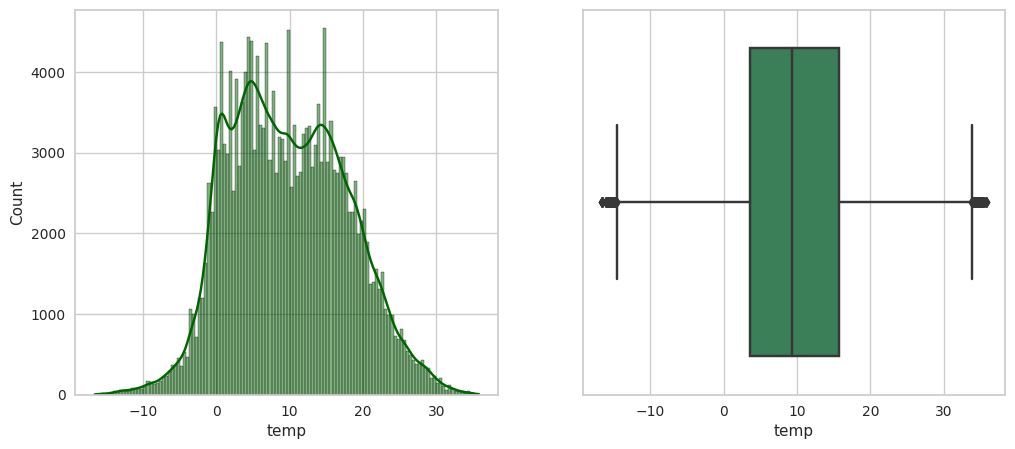

In [8]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

sns.histplot(data = df['temp'], color = 'DarkGreen', kde = True, ax = axes[0])

sns.boxplot(x = df['temp'], color = 'SeaGreen', ax = axes[1])

plt.show()

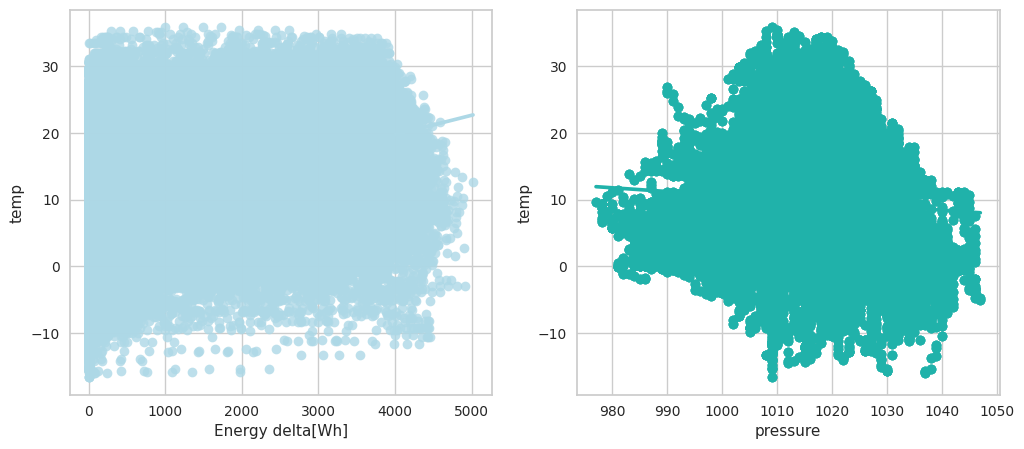

In [9]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

sns.regplot(data = df, 
            x = 'Energy delta[Wh]', 
            y = 'temp', 
            ax = axes[0],
            color = 'LightBlue'
           )

sns.regplot(data = df, 
           x = 'pressure', 
           y = 'temp', 
           ax = axes[1],
           color = 'LightSeaGreen'
          )

plt.show()

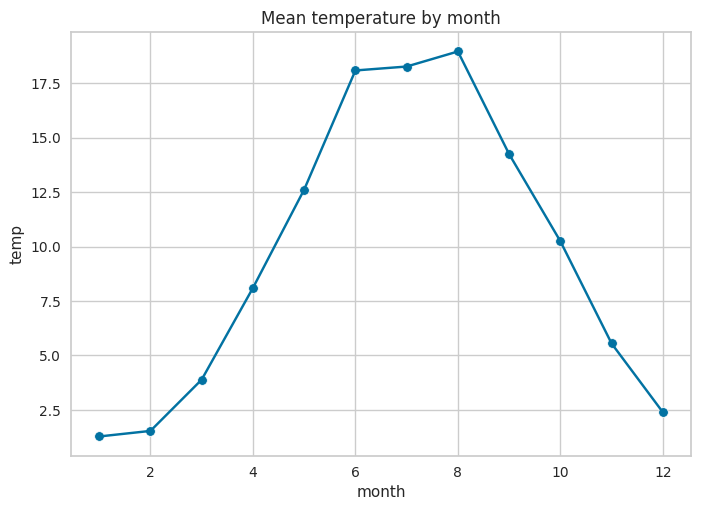

In [10]:
mean_temp_by_month = df.groupby('month')[['temp']].mean()

sns.scatterplot(x = mean_temp_by_month.index, 
                y = mean_temp_by_month.temp
               )

sns.lineplot(x = mean_temp_by_month.index, 
             y = mean_temp_by_month.temp
            ).set_title('Mean temperature by month')

plt.show()

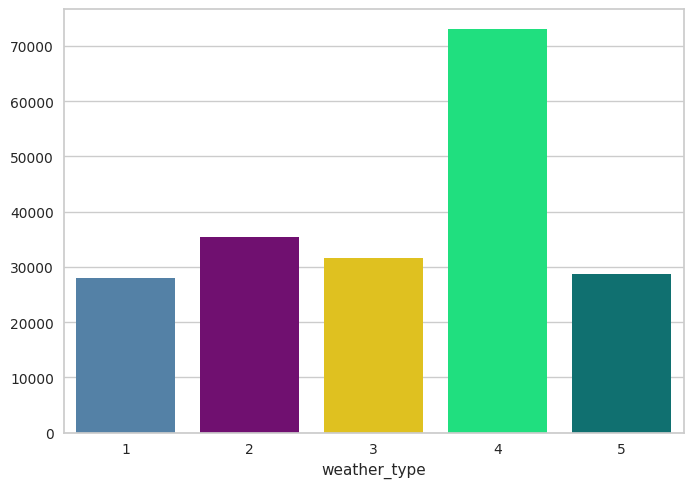

In [11]:
weather_type_counts = df['weather_type'].value_counts()

sns.barplot(x = weather_type_counts.index, 
            y = weather_type_counts.values, 
            palette = ['steelblue', 'purple', 'gold', 'springgreen', 'teal']
           )

plt.show()

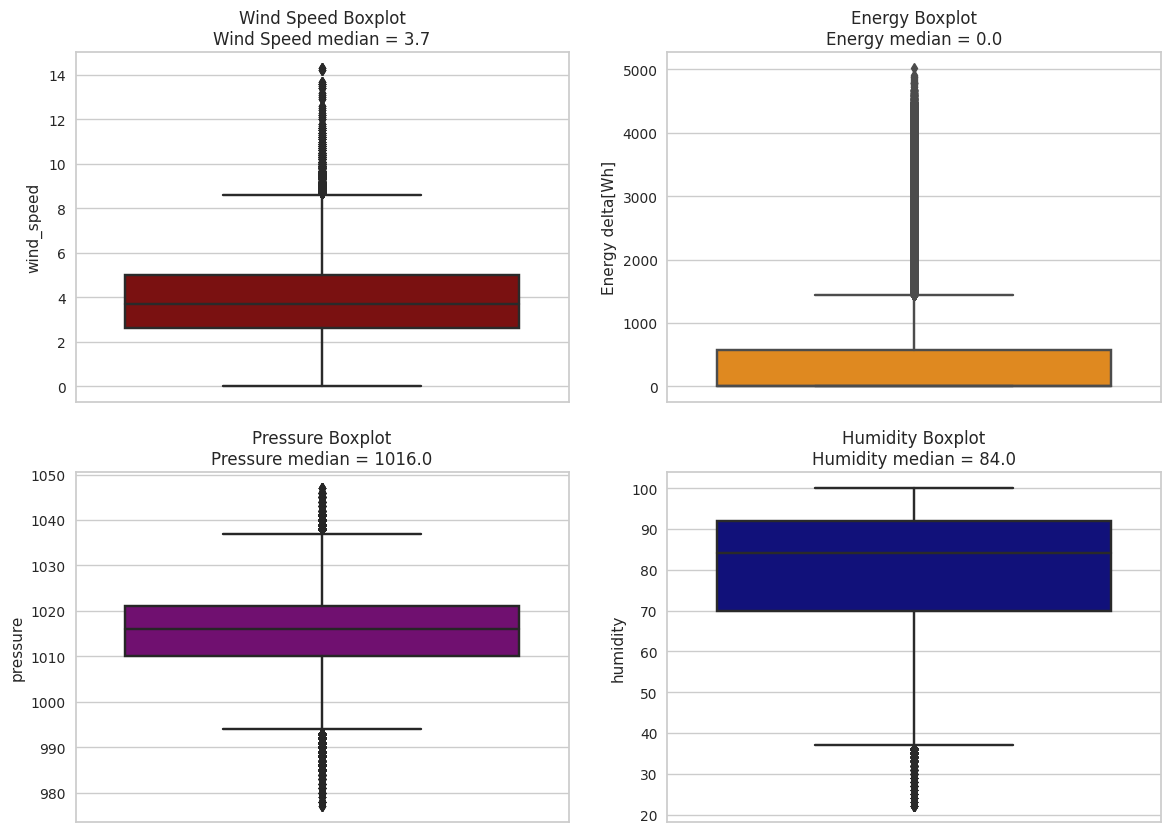

In [12]:
fig, axes = plt.subplots(2, 2, figsize = (14, 10))

wind_speed_title = f"Wind Speed Boxplot\nWind Speed median = {df['wind_speed'].median()}"
sns.boxplot(data = df, y = 'wind_speed', color = 'DarkRed', ax = axes[0][0]).set_title(wind_speed_title)

energy_title = f"Energy Boxplot\nEnergy median = {df['Energy delta[Wh]'].median()}"
sns.boxplot(data = df, y = 'Energy delta[Wh]', color = 'DarkOrange', ax = axes[0][1]).set_title(energy_title)

pressure_title = f"Pressure Boxplot\nPressure median = {df['pressure'].median()}"
sns.boxplot(data = df, y = 'pressure', color = 'Purple', ax = axes[1][0]).set_title(pressure_title)

humidity_title = f"Humidity Boxplot\nHumidity median = {df['humidity'].median()}"
sns.boxplot(data = df, y = 'humidity', color = 'DarkBlue', ax = axes[1][1]).set_title(humidity_title)

plt.show()

In [13]:
numeric_features = df.drop(columns = ['isSun', 'weather_type'])

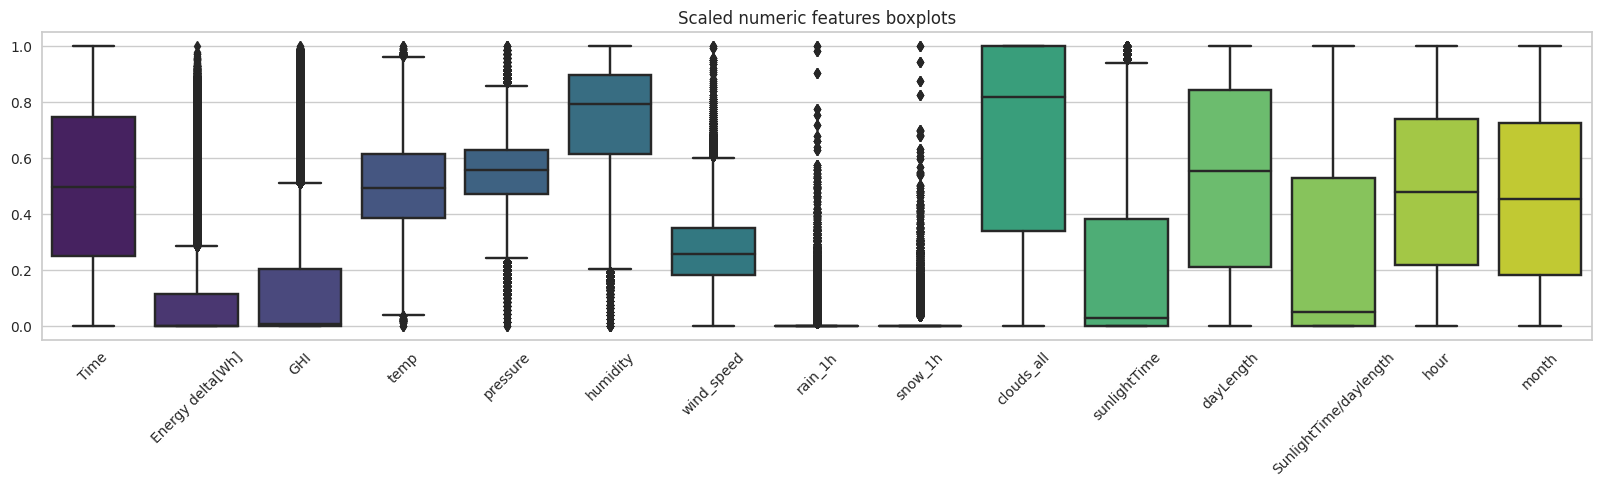

In [14]:
numeric_data = numeric_features.copy()

for feature in numeric_data.columns:
    numeric_data[feature] -= np.min(numeric_data[feature])
    numeric_data[feature] /= np.max(numeric_data[feature])

fig, ax = plt.subplots(figsize = (20, 4))
    
sns.boxplot(data = numeric_data, palette = "viridis").set_title("Scaled numeric features boxplots")

plt.xticks(rotation = 45)

plt.show()

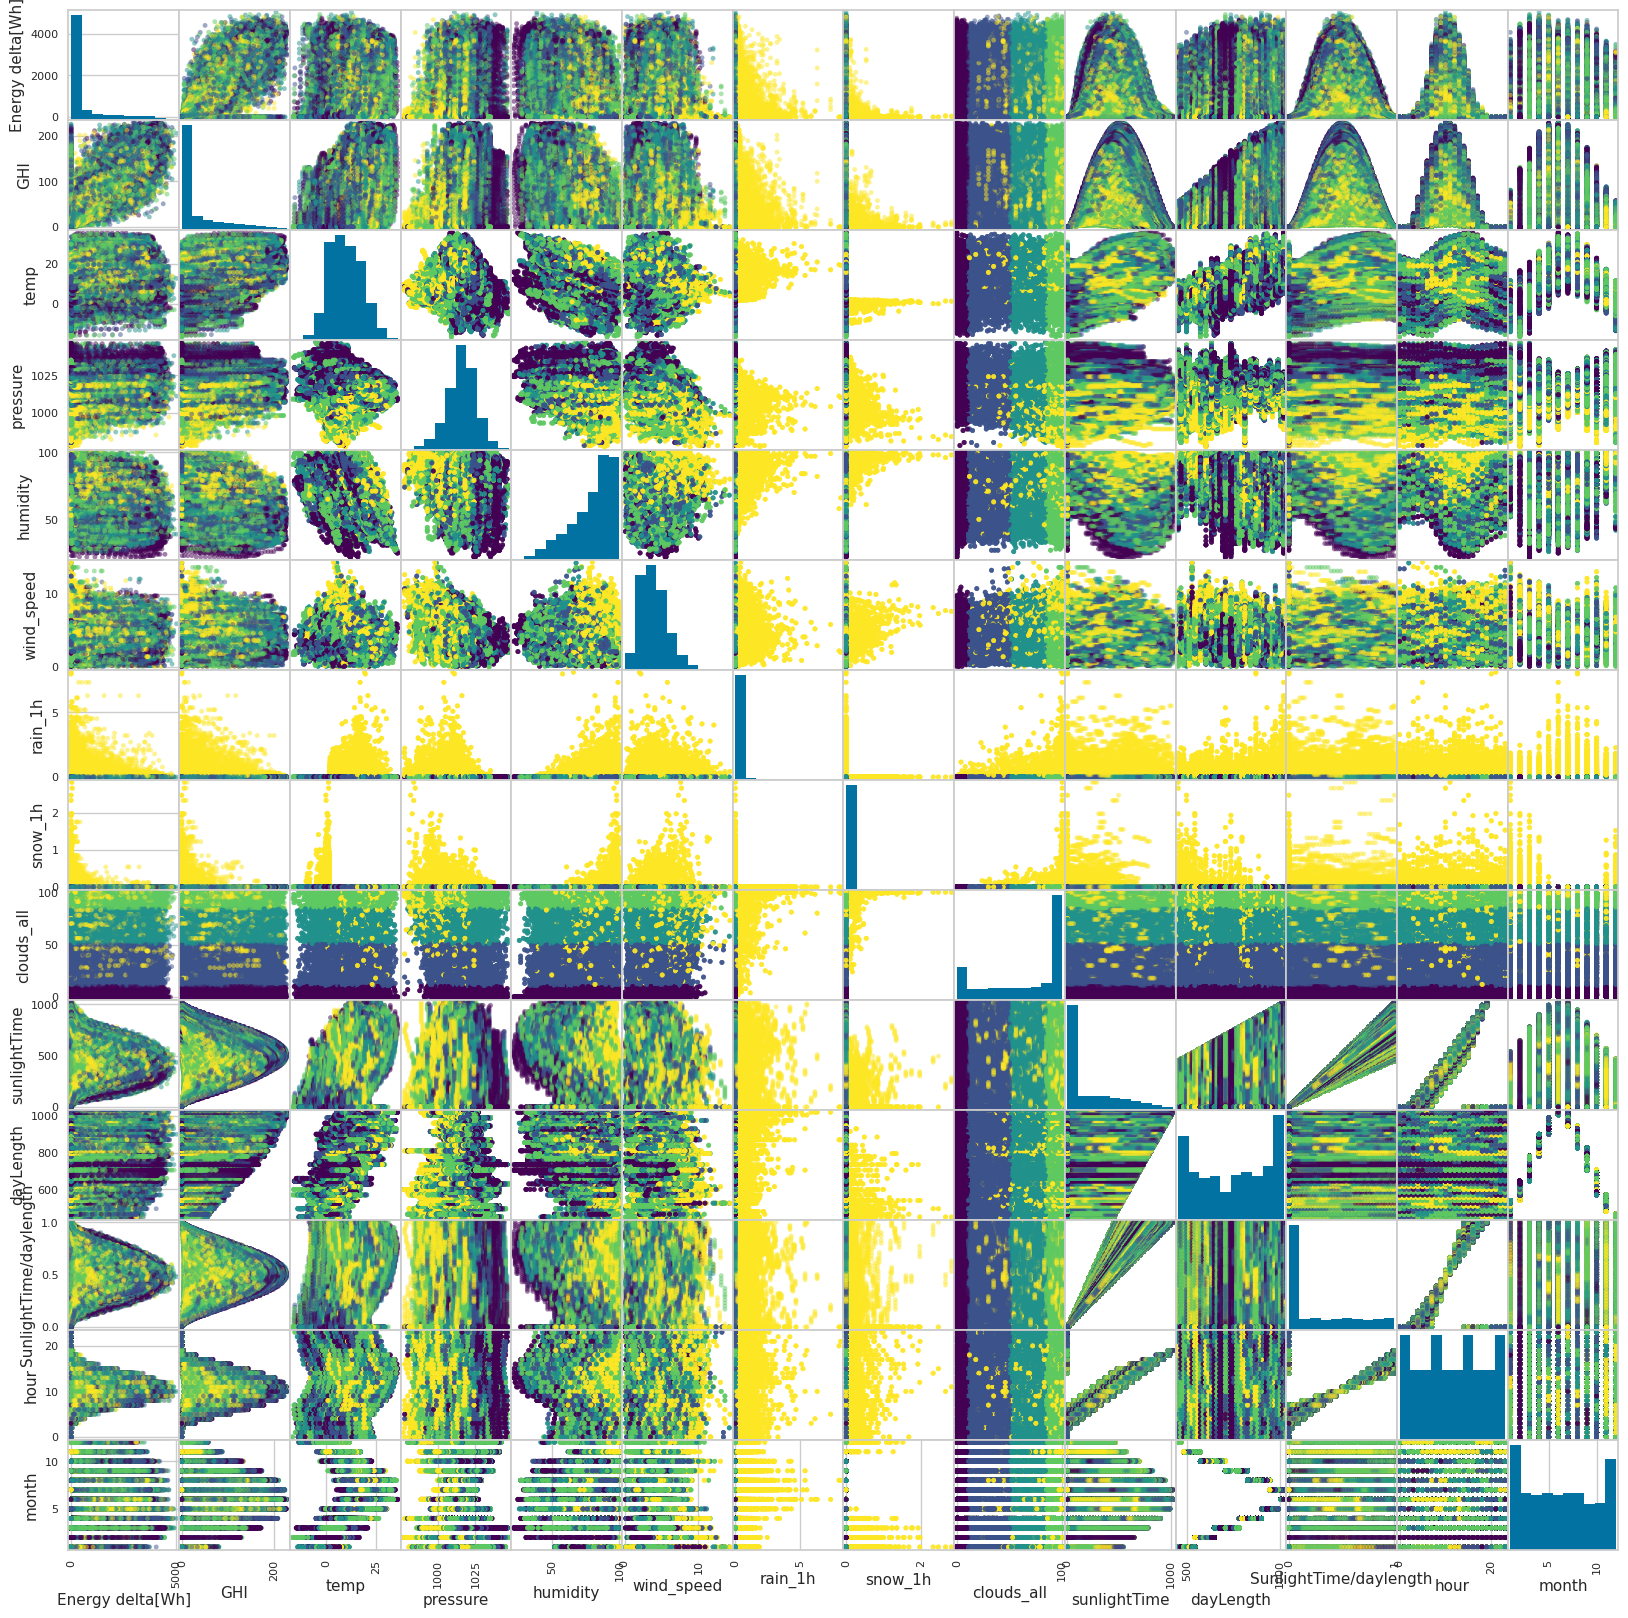

In [15]:
pd.plotting.scatter_matrix(numeric_features, c = df['weather_type'], figsize = (20, 20), cmap = 'viridis')

plt.show()

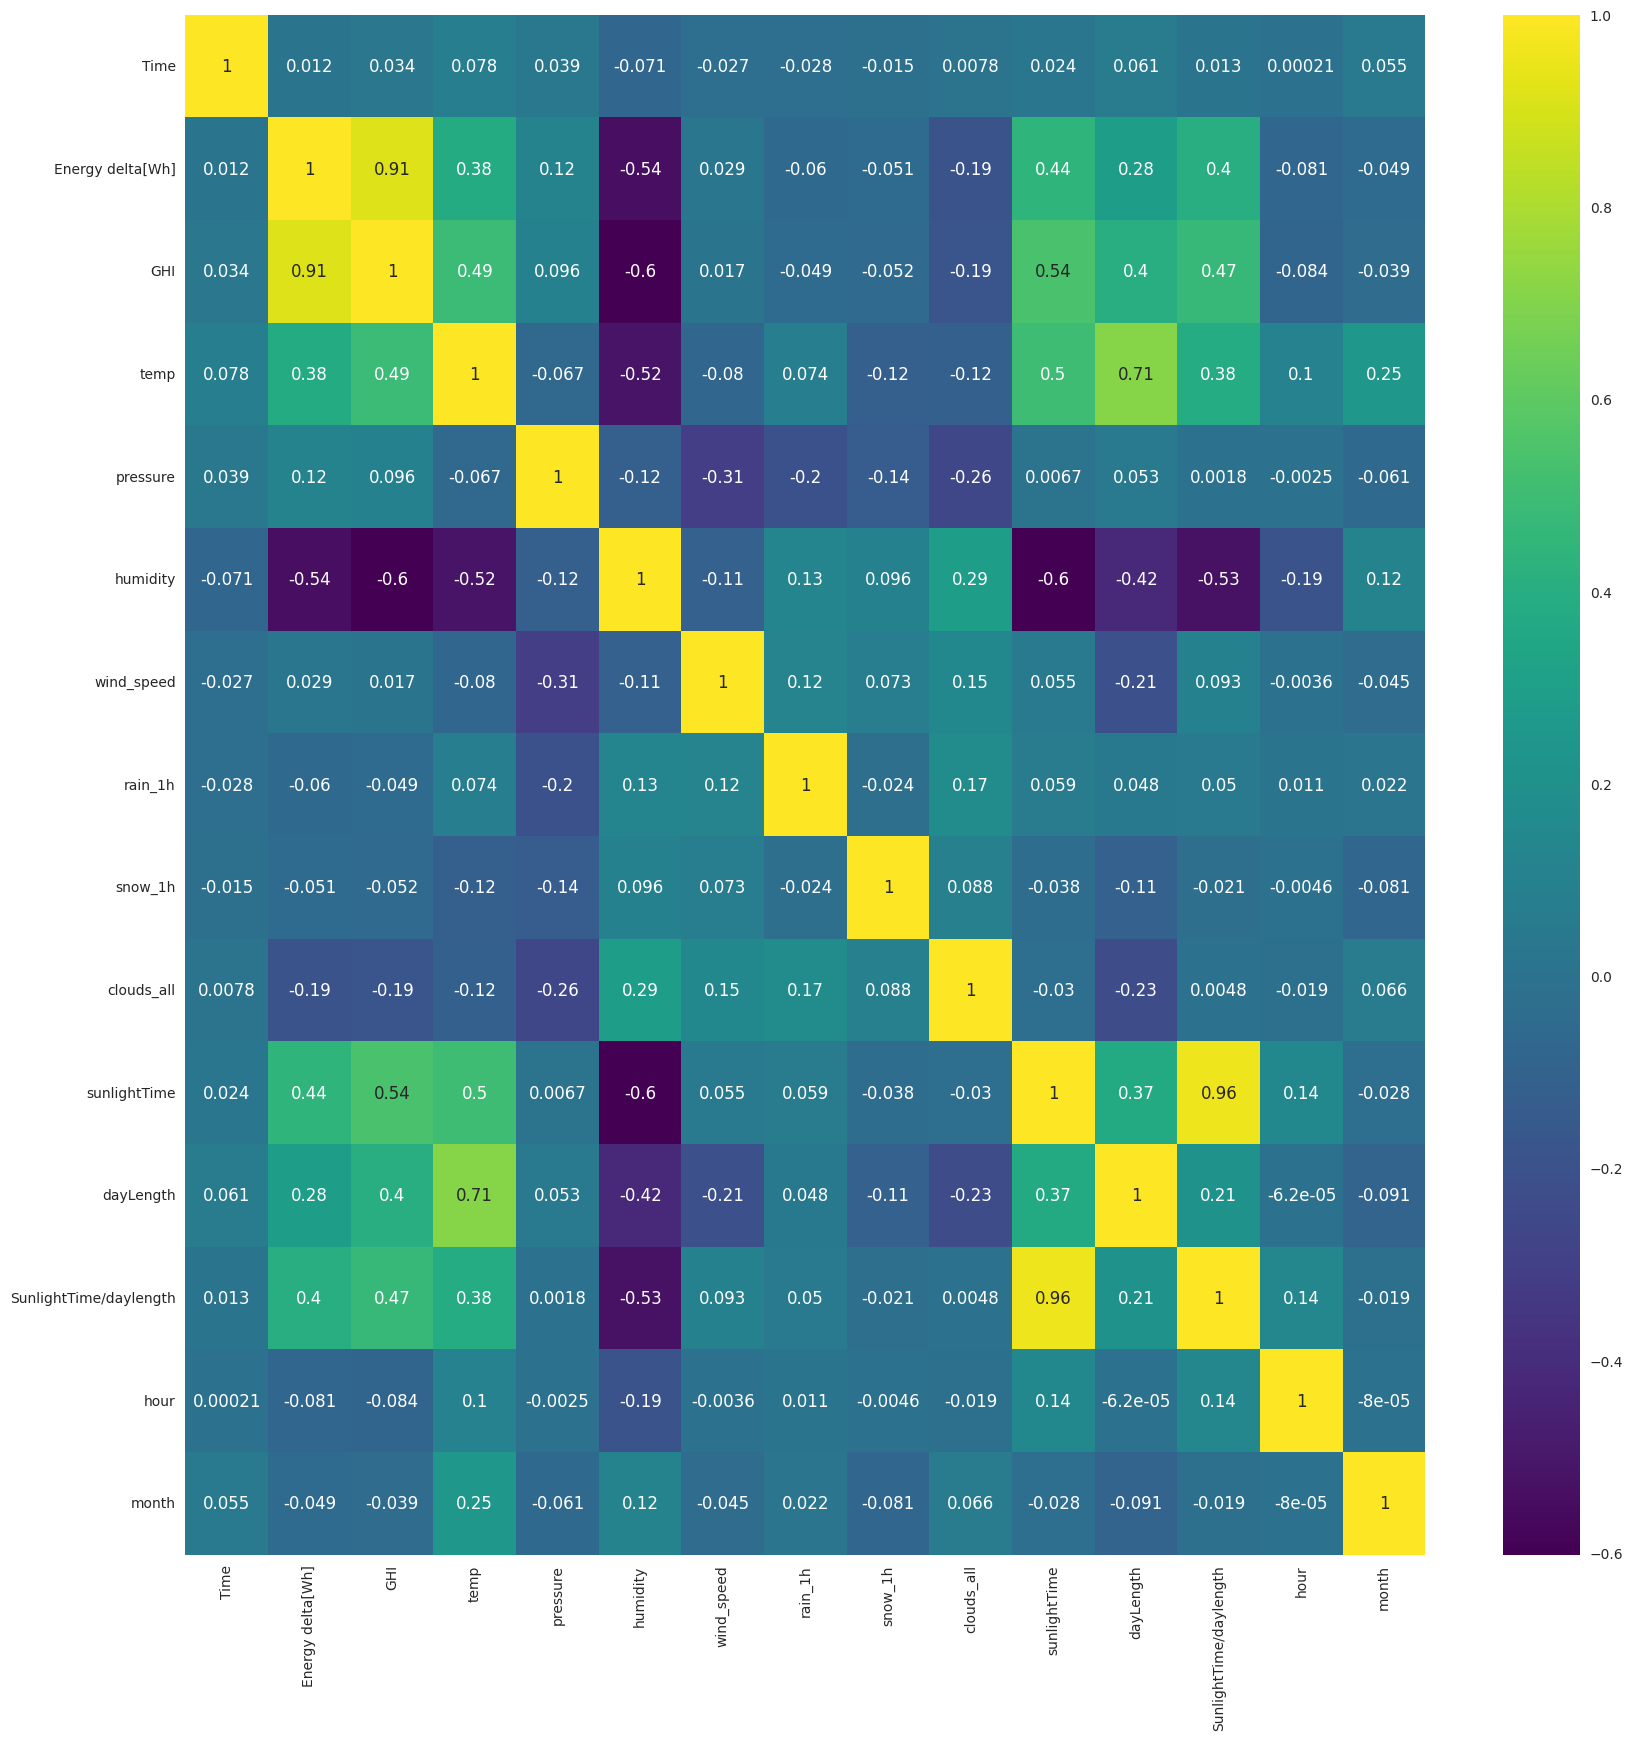

In [16]:
fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(numeric_features.corr(), annot = True, cmap = 'viridis')
plt.show()

O heatmap acima indica a correlação, usando o método de Pearson, entre os atributos numéricos do dataset. A partir do gráfico, é possível observar uma forte correlação positiva entre a energia produzida e o GHI (global horizontal irradiance).<br> 
Por outro lado, nota-se também uma forte correlação negativa entre o tempo de luminosidade e a humidade.

In [17]:
X = df.drop(columns = ['temp', 'Time'])
y = df['temp']

In [18]:
numeric_X_features = ['Energy delta[Wh]', 'GHI', 'pressure', 'humidity',
       'wind_speed', 'rain_1h', 'snow_1h', 'clouds_all',
       'sunlightTime', 'dayLength', 'SunlightTime/daylength',
       'hour', 'month']

categorical_X_features = ['weather_type']

In [19]:
preprocessor = ColumnTransformer(transformers = 
                                    [("numeric", StandardScaler(), numeric_X_features),
                                     ("categorical", OneHotEncoder(handle_unknown = "ignore"), categorical_X_features)]
                                ) 

In [20]:
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                    test_size = 0.6, 
                                                    random_state = 42
                                                   )

print(f"X Train shape = {train_X.shape}")
print(f"y Train shape = {train_y.shape}")
print(f"X Test shape = {test_X.shape}")
print(f"y Test shape = {test_y.shape}")

X Train shape = (78710, 15)
y Train shape = (78710,)
X Test shape = (118066, 15)
y Test shape = (118066,)


In [21]:
rlinear = Pipeline([('preprocessor', preprocessor),
                    ('linear_reg', LinearRegression())
                   ])

rlinear.fit(train_X, train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['Energy delta[Wh]', 'GHI',
                                                   'pressure', 'humidity',
                                                   'wind_speed', 'rain_1h',
                                                   'snow_1h', 'clouds_all',
                                                   'sunlightTime', 'dayLength',
                                                   'SunlightTime/daylength',
                                                   'hour', 'month']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['weather_type'])])),
                ('linear_reg', LinearRegression())])

In [22]:
print(f"Linear regression train r2 score = {rlinear.score(train_X, train_y)}")
print(f"Linear regression test r2 score = {rlinear.score(test_X, test_y)}")

Linear regression train r2 score = 0.7178712660677808
Linear regression test r2 score = 0.7178283327939523


In [23]:
linear_scores = cross_val_score(Pipeline([('preprocessor', preprocessor), 
                                          ('linear_reg', LinearRegression())
                                         ]), 
                                X, y, cv = 5, n_jobs = 4
                               )

In [24]:
print(f"Cross val scores for linear regression = {linear_scores}")
print(f"Mean cross val scores = {linear_scores.mean()}")
print(f"Cross val scores standard deviation = {linear_scores.std()}")

Cross val scores for linear regression = [0.74402382 0.71533643 0.61559742 0.72891572 0.70780119]
Mean cross val scores = 0.7023349166299326
Cross val scores standard deviation = 0.0450928293101272


In [25]:
ridge_grid_param = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]} 

ridge_pipe = Pipeline([('preprocessor', preprocessor), ('ridge', Ridge())])

ridge = GridSearchCV(ridge_pipe, ridge_grid_param, cv = 5)

ridge.fit(train_X, train_y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         ['Energy '
                                                                          'delta[Wh]',
                                                                          'GHI',
                                                                          'pressure',
                                                                          'humidity',
                                                                          'wind_speed',
                                                                          'rain_1h',
                                                                          'snow_1h',
                                                                          'clouds_all',
                                                                          'sunlightTime',
                                                                          'dayLength',
                                                                          'SunlightTime/daylength',
                                                                          'hour',
                                                                          'month']),
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['weather_type'])])),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [0.01, 0.1, 1, 10, 100]})

In [26]:
print(f"Ridge train r2 score = {ridge.score(train_X, train_y)}")
print(f"Ridge test r2 score = {ridge.score(test_X, test_y)}")

Ridge train r2 score = 0.7178712364927125
Ridge test r2 score = 0.7178281845099936


In [27]:
print(f"Best parameter for ridge = {ridge.best_estimator_.named_steps['ridge']}")

Best parameter for ridge = Ridge(alpha=10)


In [28]:
elastic_net = Pipeline([('preprocessor', preprocessor), 
                        ('elast_net', ElasticNet(random_state = 42, alpha = 0.001))
                       ])

elastic_net.fit(train_X, train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['Energy delta[Wh]', 'GHI',
                                                   'pressure', 'humidity',
                                                   'wind_speed', 'rain_1h',
                                                   'snow_1h', 'clouds_all',
                                                   'sunlightTime', 'dayLength',
                                                   'SunlightTime/daylength',
                                                   'hour', 'month']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['weather_type'])])),
                ('elast_net', ElasticNet(alpha=0.001, random_state=42))])

In [29]:
print(f"Elastic Net train r2 score = {elastic_net.score(train_X, train_y)}")
print(f"Elastic Net test r2 score = {elastic_net.score(test_X, test_y)}")

Elastic Net train r2 score = 0.7178680441454018
Elastic Net test r2 score = 0.7178211919370987


In [30]:
elastic_scores = cross_val_score(Pipeline([('preprocessor', preprocessor), 
                                           ('elast_net', ElasticNet(random_state = 42, alpha = 0.001))
                                          ]),
                                 X, y, cv = 5, n_jobs = 4
                                )

In [31]:
print(f"Cross val scores for elastic net = {elastic_scores}")
print(f"Mean cross val scores = {elastic_scores.mean()}")
print(f"Cross val scores standard deviation = {elastic_scores.std()}")

Cross val scores for elastic net = [0.7440802  0.71521398 0.61579891 0.72888319 0.70780381]
Mean cross val scores = 0.7023560177999532
Cross val scores standard deviation = 0.045014969517455046


In [32]:
svr = Pipeline([('preprocessor', preprocessor), ('svr', SVR(C = 100, gamma = 0.01))])

svr.fit(train_X, train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['Energy delta[Wh]', 'GHI',
                                                   'pressure', 'humidity',
                                                   'wind_speed', 'rain_1h',
                                                   'snow_1h', 'clouds_all',
                                                   'sunlightTime', 'dayLength',
                                                   'SunlightTime/daylength',
                                                   'hour', 'month']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['weather_type'])])),
                ('svr', SVR(C=100, gamma=0.01))])

In [33]:
print(f"SVR train r2 score = {svr.score(train_X, train_y)}")
print(f"SVR test r2 score = {svr.score(test_X, test_y)}")

SVR train r2 score = 0.8460839490992615
SVR test r2 score = 0.8468585789758777


In [34]:
forest = RandomForestRegressor(random_state = 42, 
                               n_estimators = 154, 
                               max_leaf_nodes = 704, 
                               n_jobs = 2 
                              )

forest.fit(train_X, train_y)

RandomForestRegressor(max_leaf_nodes=704, n_estimators=154, n_jobs=2,
                      random_state=42)

In [35]:
print(f"Random forest train r2 score = {forest.score(train_X, train_y)}")
print(f"Random forest test r2 score = {forest.score(test_X, test_y)}")

Random forest train r2 score = 0.9161730208976073
Random forest test r2 score = 0.9058999746259274


In [36]:
permutation = PermutationImportance(forest, random_state = 1).fit(test_X, test_y)
eli5.show_weights(permutation, feature_names = test_X.columns.tolist())

In [37]:
forest_scores = cross_val_score(RandomForestRegressor(random_state = 42, 
                                                      n_estimators = 154, 
                                                      max_leaf_nodes = 704
                                                     ), 
                                X, y, cv = 5, n_jobs = 4
                               )

In [38]:
print(f"Cross val scores for random forest = {forest_scores}")
print(f"Mean cross val scores = {forest_scores.mean()}")
print(f"Cross val scores standard deviation = {forest_scores.std()}")

Cross val scores for random forest = [0.79657589 0.74183204 0.73982667 0.816772   0.81445509]
Mean cross val scores = 0.7818923367020263
Cross val scores standard deviation = 0.03425457039998023


In [39]:
histboost = HistGradientBoostingRegressor(random_state = 42, 
                                          learning_rate = 0.11, 
                                          max_leaf_nodes = 38, 
                                          scoring = "r2"
                                         )

histboost.fit(train_X, train_y)

HistGradientBoostingRegressor(learning_rate=0.11, max_leaf_nodes=38,
                              random_state=42, scoring='r2')

In [40]:
print(f"Histogram Gradient Boosting train r2 score = {histboost.score(train_X, train_y)}")
print(f"Histogram Gradient Boosting test r2 score = {histboost.score(test_X, test_y)}")

Histogram Gradient Boosting train r2 score = 0.8991882170948482
Histogram Gradient Boosting test r2 score = 0.8936883534481503


In [41]:
histboost_scores = cross_val_score(HistGradientBoostingRegressor(random_state = 42, 
                                                                 learning_rate = 0.11, 
                                                                 max_leaf_nodes = 38, 
                                                                 scoring = "r2"
                                                                ),
                                   X, y, cv = 5, n_jobs = 4
                                  )

In [42]:
print(f"Cross val scores for Histogram Gradient Boosting = {histboost_scores}")
print(f"Mean cross val scores = {histboost_scores.mean()}")
print(f"Cross val scores standard deviation = {histboost_scores.std()}")

Cross val scores for Histogram Gradient Boosting = [0.84120649 0.7633031  0.77418261 0.82822045 0.84447287]
Mean cross val scores = 0.8102771033209641
Cross val scores standard deviation = 0.0345175634479042


In [43]:
lgbr_X = X.copy()

lgbr_X = lgbr_X.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

lgbr_train_X, lgbr_test_X, lgbr_train_y, lgbr_test_y = train_test_split(lgbr_X, y, 
                                                                        random_state = 42, 
                                                                        test_size = 0.6
                                                                       ) 

In [44]:
lgbmr = LGBMRegressor(n_estimators = 674,
                      max_depth = 21, 
                      learning_rate = 0.12, 
                      num_leaves = 32, 
                      boosting  = 'gbdt'
                     )

lgbmr.fit(lgbr_train_X, lgbr_train_y)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


LGBMRegressor(boosting='gbdt', learning_rate=0.12, max_depth=21,
              n_estimators=674, num_leaves=32)

In [45]:
print(f"LGBM train r2 score = {lgbmr.score(lgbr_train_X, lgbr_train_y)}")
print(f"LGBM test r2 score = {lgbmr.score(lgbr_test_X, lgbr_test_y)}")

LGBM train r2 score = 0.9512374568227118
LGBM test r2 score = 0.9365342206259903


In [46]:
lgbmr_scores = cross_val_score(LGBMRegressor(n_estimators = 674,
                                            max_depth = 21, 
                                            learning_rate = 0.12, 
                                            num_leaves = 32, 
                                            boosting  = 'goss'
                                           ), 
                              lgbr_X, y,
                              cv = 5,
                              n_jobs = 4
                             )

In [47]:
print(f"LGBM scores = {lgbmr_scores}")
print(f"LGBM mean score = {lgbmr_scores.mean()}")
print(f"LGBM score standard deviation = {lgbmr_scores.std()}")

LGBM scores = [0.82864355 0.75190632 0.75712712 0.82013035 0.83209269]
LGBM mean score = 0.7979800036763736
LGBM score standard deviation = 0.03573879769947895


In [48]:
xgbr = Pipeline([
         ('scaler', StandardScaler()),
         ('xgbr', XGBRegressor(random_state = 1,
                               n_estimators = 200, 
                               learning_rate = 0.1,
                               base_score = 0.5
                              )
         ) 
        ])

xgbr.fit(train_X, train_y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('xgbr',
                 XGBRegressor(base_score=0.5, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=200,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=1, ...))])

In [49]:
print(f"XGBoost train r2 score = {xgbr.score(train_X, train_y)}")
print(f"XGBoost test r2 score = {xgbr.score(test_X, test_y)}")

XGBoost train r2 score = 0.9143454521615716
XGBoost test r2 score = 0.9059562649877124


In [50]:
xgbr_scores = cross_val_score(
                Pipeline([
                    ('scaler', StandardScaler()),
                    ('xgbr', XGBRegressor(random_state = 1,
                                          n_estimators = 200, 
                                          learning_rate = 0.1,
                                          base_score = 0.5
                                         ))
                ]), X, y, cv = 5, n_jobs = 2
              )

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss


In [51]:
print(f"Cross val scores for XGBoost = {xgbr_scores}")
print(f"Mean cross val scores = {xgbr_scores.mean()}")
print(f"Cross val scores standard deviation = {xgbr_scores.std()}")

Cross val scores for XGBoost = [0.83538042 0.75971684 0.76806348 0.82615629 0.83790243]
Mean cross val scores = 0.8054438895898197
Cross val scores standard deviation = 0.03425496917039167


In [52]:
scaler = StandardScaler().fit(train_X)

train_X_scaled = scaler.transform(train_X)
test_X_scaled = scaler.transform(test_X)

In [53]:
neural_net = tf.keras.Sequential([
                layers.Dense(128, input_shape = [train_X_scaled.shape[1]], activation = 'relu'),
                layers.Dense(16, activation = 'relu'),
                layers.Dense(8),
                layers.Dense(1)
             ])

In [54]:
neural_net.compile(optimizer = 'adam',
                   loss = 'mse',
                   metrics = ['mean_absolute_error']
                  )

In [55]:
history = neural_net.fit(train_X_scaled, 
                         train_y, 
                         validation_data = (test_X_scaled, test_y),
                         epochs = 14
                        )

Epoch 1/14
2460/2460 [==============================] - 10s 4ms/step - loss: 13.2592 - mean_absolute_error: 2.7461 - val_loss: 10.2549 - val_mean_absolute_error: 2.4768
Epoch 2/14
2460/2460 [==============================] - 9s 4ms/step - loss: 10.2276 - mean_absolute_error: 2.4746 - val_loss: 9.8841 - val_mean_absolute_error: 2.4247
Epoch 3/14
2460/2460 [==============================] - 9s 4ms/step - loss: 9.8631 - mean_absolute_error: 2.4297 - val_loss: 9.6057 - val_mean_absolute_error: 2.3926
Epoch 4/14
2460/2460 [==============================] - 9s 4ms/step - loss: 9.6256 - mean_absolute_error: 2.3990 - val_loss: 9.5411 - val_mean_absolute_error: 2.3833
Epoch 5/14
2460/2460 [==============================] - 9s 4ms/step - loss: 9.4408 - mean_absolute_error: 2.3750 - val_loss: 9.6057 - val_mean_absolute_error: 2.3826
Epoch 6/14
2460/2460 [==============================] - 9s 4ms/step - loss: 9.2454 - mean_absolute_error: 2.3513 - val_loss: 8.9988 - val_mean_absolute_error: 2.3188


In [56]:
history_df = pd.DataFrame(history.history)

display(history_df.head())

loss  mean_absolute_error   val_loss  val_mean_absolute_error
0  13.259172             2.746051  10.254912                 2.476801
1  10.227612             2.474556   9.884061                 2.424746
2   9.863109             2.429714   9.605748                 2.392578
3   9.625611             2.398972   9.541067                 2.383294
4   9.440833             2.374969   9.605708                 2.382589

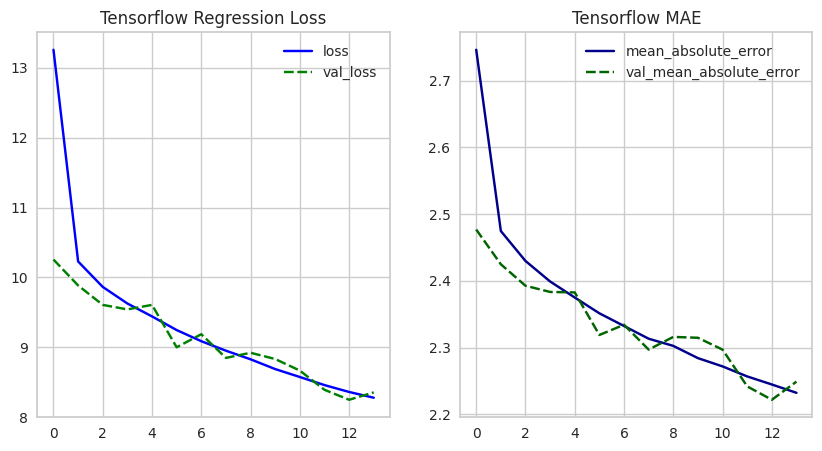

In [57]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

sns.lineplot(history_df.loc[:, ['loss', 'val_loss']], 
             ax = axes[0], 
             palette = ['Blue', 'Green']
            ).set(title = "Tensorflow Regression Loss")

sns.lineplot(history_df.loc[:, ['mean_absolute_error', 'val_mean_absolute_error']], 
             ax = axes[1], 
             palette = ['DarkBlue', 'DarkGreen']
            ).set(title = "Tensorflow MAE")

plt.show()

In [58]:
predict_train_y = neural_net.predict(train_X_scaled) 
predict_y = neural_net.predict(test_X_scaled)

3690/3690 [==============================] - 4s 1ms/step


In [59]:
print(f"Neural Network train r2 score = {r2_score(predict_train_y, train_y)}")
print(f"Neural Network test r2 score = {r2_score(predict_y, test_y)}")

Neural Network train r2 score = 0.8451739976427106
Neural Network test r2 score = 0.8393969505326355


In [60]:
pca = PCA(n_components = 2)
pca.fit(X)

PCA(n_components=2)

In [61]:
X_pca = pca.transform(X)
print("Original shape: ", X.shape)
print("Transformed shape: ", X_pca.shape)

Original shape:  (196776, 15)
Transformed shape:  (196776, 2)


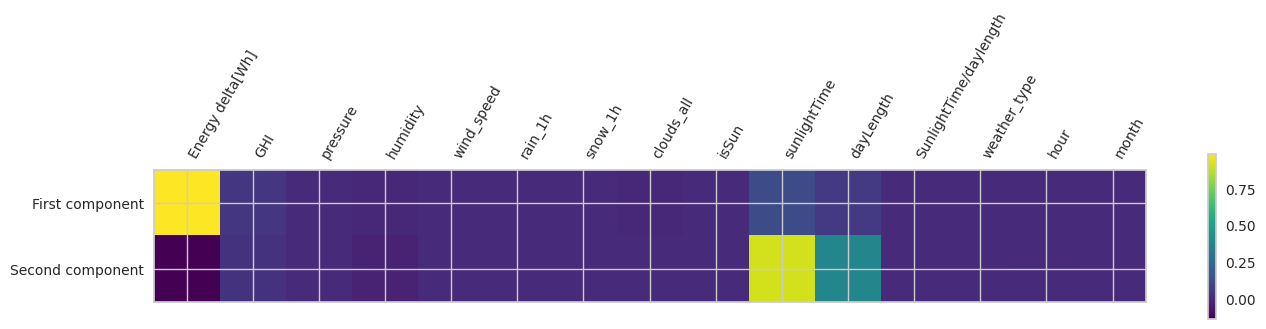

In [62]:
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(X.columns)), X.columns, rotation = 60, ha = 'left')
plt.show()

In [63]:
# print best features by name and by most important to least important
print(f"Best features by name: {X.columns[np.argsort(pca.components_[0])][::-1]}\n")
print(f"Best features by importance: {np.sort(pca.components_[0])[::-1]}\n")

Best features by name: Index(['Energy delta[Wh]', 'sunlightTime', 'dayLength', 'GHI', 'pressure',
       'isSun', 'SunlightTime/daylength', 'wind_speed', 'snow_1h', 'rain_1h',
       'month', 'weather_type', 'hour', 'clouds_all', 'humidity'],
      dtype='object')

Best features by importance: [ 9.90042056e-01  1.20825669e-01  5.50620343e-02  4.55248472e-02
  1.03650257e-03  2.57790717e-04  1.33521632e-04  4.90666024e-05
 -3.46263778e-06 -1.49507663e-05 -1.60971022e-04 -2.06889219e-04
 -4.91755329e-04 -6.61923335e-03 -8.26194848e-03]



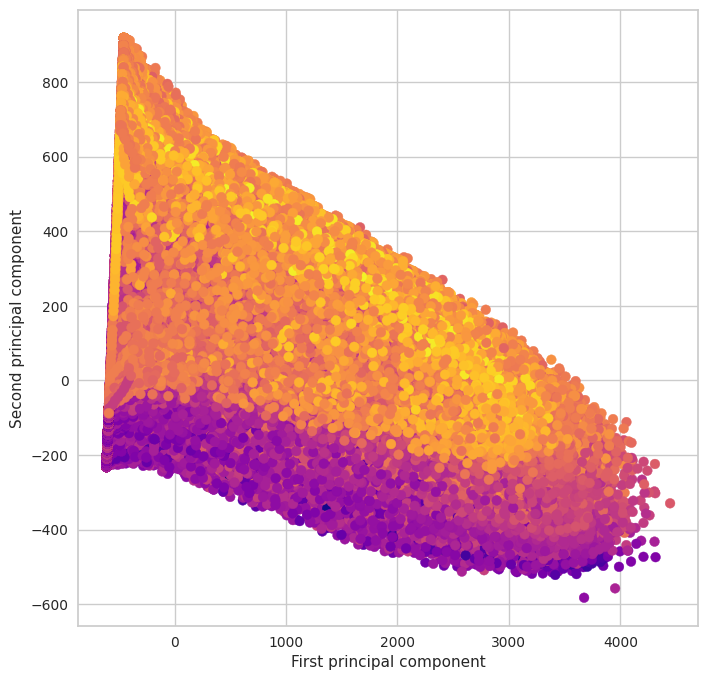

In [64]:
plt.figure(figsize = (8, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = y, cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.show()

In [65]:
viz = ValidationCurve(
        RandomForestRegressor(random_state = 1), 
        param_name = "max_leaf_nodes",
        param_range = [10**x + 1 for x in range(1, 5)], 
        cv = 5, scoring = "r2",
        logx = True,
        n_jobs = 4
      )

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss


ValidationCurve(ax=<Axes: >, cv=5,
                estimator=RandomForestRegressor(random_state=1), logx=True,
                n_jobs=4, param_name='max_leaf_nodes',
                param_range=array([   11,   101,  1001, 10001]), scoring='r2')

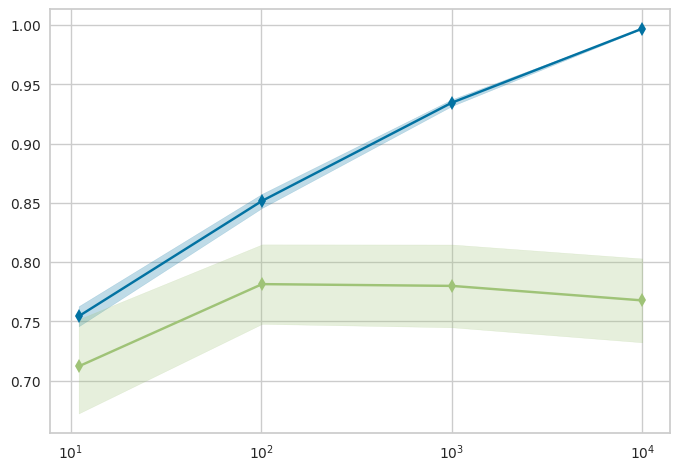

In [66]:
viz.fit(X, y)